# Programming PyTorch for Deep Learning

---


Creating and Deploying Deep Learning Applications"

Ian Pointer

**Ссылка на исходные материалы в GitHub**: https://github.com/falloutdurham/beginners-pytorch-deep-learning

---



# Часть 6: Путешествие в мир звуков

(Внимание: в примере кода тиспользовались PyTorch 1.6 и torchaudio 0.6.0)

Загрузите дата-сет аудиозаписей ESC-50 по ссылке https://github.com/karolpiczak/ESC-50#download
Записи размечены на 50 классов. В имени файлов последнее число ,обозначает к какому классу был присвоен этот файл звукозаписи.

In [1]:
# Подключение к Google-диску, где хранятся анные и будут сохраняться модели.
# При запуске модуля будет показана ссылка - кликайте на неё и входите через свой аккаунт.
# Копируйте ключ и вставьте его в окошко...
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
# Проверяем наличие доступа к директории, в которой будет сохраняться модель
%cd '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/'
%ls

/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master
audio/     LICENSE     meta/       README.md         tests/
esc50.gif  master.zip  pytest.ini  requirements.txt


## Загружаем себе дата сет из GitHub

В книге это предлагается сделать командой `https://github.com/karoldvl/ESC-50/archive/master.zip`, но у меня не получается. Скачал командой `wget` в каталог `/content`

In [3]:
%cd /content
!wget https://github.com/karoldvl/ESC-50/archive/master.zip

/content
--2021-07-05 15:51:44--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2021-07-05 15:51:44--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/master [following]
--2021-07-05 15:51:44--  https://codeload.github.com/karolpiczak/ESC-50/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [<=>       

In [4]:
!unzip master.zip
!rm master.zip
!ls

Archive:  master.zip
5ade7ae821cd420f0df92fe61409fc1fce50a3bf
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-master/.circleci/config.yml  
   creating: ESC-50-master/.github/
  inflating: ESC-50-master/.github/stale.yml  
 extracting: ESC-50-master/.gitignore  
  inflating: ESC-50-master/LICENSE   
  inflating: ESC-50-master/README.md  
   creating: ESC-50-master/audio/
  inflating: ESC-50-master/audio/1-100032-A-0.wav  
  inflating: ESC-50-master/audio/1-100038-A-14.wav  
  inflating: ESC-50-master/audio/1-100210-A-36.wav  
  inflating: ESC-50-master/audio/1-100210-B-36.wav  
  inflating: ESC-50-master/audio/1-101296-A-19.wav  
  inflating: ESC-50-master/audio/1-101296-B-19.wav  
  inflating: ESC-50-master/audio/1-101336-A-30.wav  
  inflating: ESC-50-master/audio/1-101404-A-34.wav  
  inflating: ESC-50-master/audio/1-103298-A-9.wav  
  inflating: ESC-50-master/audio/1-103995-A-30.wav  
  inflating: ESC-50-master/audio/1-103999-A-30.wav  
  infla

## Для преобразований аудиозаписей нам потребуется программа SoX. 
Для системы на базе Red Hat введите следующее
`yum install sox`

Для системы на базе Debian введите следующее:
`apt intall sox`

В **Google Colaboraory** установка **SoX** выглядит несколько иначе...

In [5]:
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null

Устанавливаем модуль **torchaudio**


In [6]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 8.0MB/s 


In [7]:
# Установка Python Imaging Library
# https://pillow.readthedocs.io/en/stable/installation.html
# !python3 -m pip install --upgrade pip
# !python3 -m pip install --upgrade Pillow

Импортируем необходимые библиотеки

In [8]:
import IPython.display as display   # используется для воспроизведение аудиозаписи в JUPYTER NOTEBOOK
import librosa                      # это библиотека Python для аудиоанализа, включающая генерацию мел-спектрограмм, обнаружение ритмов и даже создание музыки.
import librosa.display
import matplotlib.pyplot as plt     # для визуализации графиков
import numpy as np
import random
import torch
import torchaudio
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pathlib import Path            # модуль для работы с директориями (используется при создании дата-сетов и загрузчиков)

# Python Imaging Library
from PIL import Image               
# Pillow >= 2.1.0 no longer supports import _imaging. Please use:
from PIL.Image import core as _imaging

from torch.utils.data import Dataset
from torchvision import models, transforms

Можем послушать записи из дата-сета.

In [9]:
# Послушаем 5-257839-A-14.wav
# Если дата-сет на нашем гугл-диске, то код такой:
display.Audio('/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/5-257839-A-14.wav')

In [10]:
# Послушаем 1-100032-A-0.wav - лай собачки
# Если дата-сет на локальном диске виртуальной машины, то код такой:
display.Audio('/content/ESC-50-master/audio/1-100032-A-0.wav')
# С файлами на локальном диске должна быть обработка пошустрее.

# Исследование данных дата-сета ESC-50

При работе с новым набором данных всегда полезно прочувствовать их форму, прежде чем погрузиться в построение моделей. Например, решая задачи классификации, вы должны узнать, действительно ли ваш набор данных содержит примеры из всех возможных классов, и в идеале нужно, чтобы все классы присутствовали в равных количествах. Давайте посмотрим, как работает ESC-50.
Мы знаем, что последний набор цифр в каждом имени файла описывает класс, к которому он принадлежит, поэтому нам нужно получить список файлов и подсчитать наличие каждого класса&

Cоздаём список файлов с меткой класса, которая закодирована в имени файла
Сначала мы формируем список имен файлов ESC-50.
Поскольку нам важен только номер класса в конце имени файла, мы «отрезаем» расширение .wav и разделяем имя файла, выделяя сепаратор. 
Далее мы берем последний элемент этой разделенной строки. 
Если вы проверите `esc50_list`, то получите пакет строк в диапазоне от 0 до 49. 
Мы могли бы написать больше кода, который компилирует `dict` и подсчитывает все экземпляры, но мне лень, поэтому я использую вспомогательную функцию `Python Counter`, которая делает все это за нас. Вот что получается:

In [11]:
# Создадим переменную для хранения пути к дата-сету
# Если дата-сет на нашем гугл-диске, то код такой:
# path2audio = "/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/"

# Если дата-сет на локальном диске виртуальной машины, то код такой:
path2audio = "/content/ESC-50-master/audio/"

import glob
from collections import Counter

esc50_list = [f.split("-")[-1].replace(".wav","") for f in 
glob.glob(path2audio + "*.wav")]
Counter(esc50_list)   # считаем кол-во файлов каждого класса
                      # Результат подсчёта показывает, что дата-сет идеально сбалансирован - в каждом классе по 40 записей.

Counter({'0': 40,
         '1': 40,
         '10': 40,
         '11': 40,
         '12': 40,
         '13': 40,
         '14': 40,
         '15': 40,
         '16': 40,
         '17': 40,
         '18': 40,
         '19': 40,
         '2': 40,
         '20': 40,
         '21': 40,
         '22': 40,
         '23': 40,
         '24': 40,
         '25': 40,
         '26': 40,
         '27': 40,
         '28': 40,
         '29': 40,
         '3': 40,
         '30': 40,
         '31': 40,
         '32': 40,
         '33': 40,
         '34': 40,
         '35': 40,
         '36': 40,
         '37': 40,
         '38': 40,
         '39': 40,
         '4': 40,
         '40': 40,
         '41': 40,
         '42': 40,
         '43': 40,
         '44': 40,
         '45': 40,
         '46': 40,
         '47': 40,
         '48': 40,
         '49': 40,
         '5': 40,
         '6': 40,
         '7': 40,
         '8': 40,
         '9': 40})

## torchaudio
На момент написания книги (2019 год) в отличие от `torchvision`, `torchaudio` как и  `torchtext` мало поддерживают и почти не обеспечивают документацией. Возможно,что на текущий день `PyTorch` стал популярнее и уже созданы более совершенные контейнеры обработки текста и аудио. Тем не менее для решения наших задач torchaudio будет вполне достаточно; нам просто нужно написать несколько специальных загрузчиков данных (чего не нужно было делать для обра- ботки аудиоданных или текста).

В любом случае ядро `torchaudio` находится в `load()` и `save()`. В этой главе мы рассмотрим только `load()`, но вам нужно будет использовать `save()`, если вы создаете новый звук с вашего входа (например, модель преобразования текста в речь). `load()` принимает файл, указанный в `filepath`, и возвращает тензорное представление аудиофайла и частоту дискретизации этого аудиофайла в виде отдельной переменной. Теперь у нас есть средства для загрузки одного из WAV-файлов из набора данных ESC-50 и преобразования его в тензор. В отличие от работы с текстом и изображениями, нам нужно написать чуть больше кода, прежде чем мы сможем приступить к созданию и обучению модели. Нам **нужно написать собственный набор данных**.


## ESC-50 Dataset & DataLoaders - Создание набора данных ESC-50 и загрузчика

В пользовательском наборе данных должны быть реализованы два метода класса `__getitem__` и `__len__`, чтобы загрузчик данных мог получить пакет тензоров и их маркировки, а также общее количество тензоров в наборе данных. У нас также есть метод `__init__` для настройки пути к файлам, которые будут неоднократно использоваться.

In [12]:
class ESC50(Dataset):
    def __init__(self,path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(str(f),f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
    def __getitem__(self, index):
        filename, label = self.items[index]
        audioTensor, rate = torchaudio.load(filename)
        return (audioTensor, int(label))     
    def __len__(self):
        return self.length

Большая часть работы в классе происходит, когда создается его новый экземпляр.

Метод `__init__` принимает параметр `path`, находит все WAV-файлы внутри этого пути и затем создает кортежи `(filename, label)`, используя тот же разделитель, чтобы получить маркировку этого аудиосемпла. Когда PyTorch запрашивает элемент из набора данных, мы индексируем его в список `items`, используем `torchaudio`. `load`, чтобы заставить `torchaudio` загрузить аудиофайл, превращаем его в тензор, а затем возвращаем как тензор, так и маркировку.

Для начала этого достаточно. 

Для проверки работоспособности давайте создадим объект ESC50 и извлечем первый элемент:

In [13]:
test_esc50 = ESC50(path2audio)
tensor, label = list(test_esc50)[0]
tensor

tensor([[-0.1329, -0.0035,  0.0627,  ..., -0.3308, -0.0208,  0.4522]])

In [14]:
tensor.shape 

torch.Size([1, 220500])

*Примечание: в `torch.Size([1, 220500])` - 220500 это кол-во семплов в 5-тисекундной записи звука с частотой 440100 Гц.*

Мы можем создать загрузчик данных, используя стандартные структуры **PyTorch**:
`example_loader = torch.utils.data.DataLoader(test_esc50, batch_size = 64, shuffle = True)`

На данный момент у нас есть только один каталог со всеми данными, что не подходит. Разделение данных в пропорции 60/20/20 на обучающие, валидационные и тестовые соответствует нашим целям. Итак, мы можем это сделать, взяв случайную выборку из всего набора данных (обеспечив выборку без замены и убедившись, что только что созданные наборы данных сбалансированы), но опять же, набор данных ESC-50 избавляет нас от необходимости выполнять большую работу. Компиляторы набора данных разделили данные на пять равных сбалансированных фолдов, обозначенных первой цифрой в имени файла. У нас будут фолды 1,2,3 — набор данных для обучения, 4 — набор данных для валидации и 5 — набор данных для теста. Но если вы не хотите быть скучным и последовательным, не бойтесь их смешивать! 

Переместите каждый фолд в каталоги тестирования, обучения и валидации:


In [15]:
# если дата-сет на локальной машине
%cd /content/ESC-50-master/audio
!mkdir train
!mkdir valid
!mkdir test
!mv 1* /content/ESC-50-master/audio/train
!mv 2* /content/ESC-50-master/audio/train
!mv 3* /content/ESC-50-master/audio/train
!mv 4* /content/ESC-50-master/audio/valid
!mv 5* /content/ESC-50-master/audio/test

/content/ESC-50-master/audio


In [16]:
# можм скописровать дата-сеты на локальный диск
# !cp /content/ESC-50-master/audio/test/*.wav /gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/test
# !cp /content/ESC-50-master/audio/valid/*.wav /gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/valid
# !cp /content/ESC-50-master/audio/train/*.wav /gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train

Теперь мы можем создавать отдельные наборы данных и загрузчики:


In [ ]:
device="cuda"
bs=64
# PATH_TO_ESC50 = Path.cwd() / '/content/ESC-50-master/audio'

train_esc50 = ESC50(path2audio + "train/")
valid_esc50 = ESC50(path2audio + "valid/")
test_esc50  = ESC50(path2audio + "test/")

train_loader = torch.utils.data.DataLoader(train_esc50, batch_size = bs, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size = bs, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test_esc50, batch_size = bs, shuffle = True)

Все данные готовы, поэтому мы можем посмотреть на модель классификации.

# M5-based CNN AudioNet
## Модель CNN для набора данных ESC-50

Для первой попытки классификации звуков мы создаем модель, которая в значительной степени построена на базе статьи под названием «Very Deep Convolutional Networks For Raw Waveforms».1 Вы увидите, что в ней используется множество составляющих, о которых я писал в главе 3, но вместо 2D-слоев мы используем 1D-слои, поскольку в нашем случае мы имеем на одну размерность меньше:

In [ ]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4) 
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, 50)

    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205) # в книге эта строка отсутствует
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.squeeze(-1)       # в книге вместо этой строки - 2 строки (см. ниже)
        x = self.fc1(x)
        return x


---

В книге часть кода `def forward` отличается от вышеприведённого:

    def forward(self, x):
      # в книге нижеследующая, закомментированная строка отсутствует
      # x = x.unsqueeze(-1).view(-1, 100, 2205) 
      x = self.conv1(x)
      x = F.relu(self.bn1(x))
      x = self.pool1(x)
      x = self.conv2(x)
      x = F.relu(self.bn2(x))
      x = self.pool2(x)
      x = self.conv3(x)
      x = F.relu(self.bn3(x))
      x = self.pool3(x)
      x = self.conv4(x)
      x = F.relu(self.bn4(x))
      x = self.pool4(x)
      x = self.avgPool(x)     # в репозитории вместо этой и последующей строк используется строка, котрая закомментирована ниже
      x = x.permute(0, 2, 1)
      # x = x.squeeze(-1)
      x = self.fc1(x)
      return F.log_softmax(x, dim = 2)

---

In [ ]:
audionet = AudioNet()
audionet.to(device)

## Скорость обучения (learning rate)
Cкорость обучения это один из самых важных гиперпараметров, который мы можем измениять.  Многие находят оптимальную скорость обучения для своих архитектур, обычно с помощью метода под названием сеточный поиск, тщательно перебирая подмножества значений скорости обучения и сравнивая результаты с контрольным набором данных.

Это отнимает невероятно много времени, и хотя люди делают именно так, часто многие ошибаются. Например, значение скорости обучения, которое эмпирически было обнаружено для работы с оптимизатором Adam, равно 3e-4. Оно известно как константа Карпатого, после того как Андрей Карпатый (в настоящее время ведущий эксперт по разработке искусственного интеллекта в Tesla) написал об этом в 2016 году в [Twitter](https://oreil.ly/WLw3q). К сожалению, мало людей прочитали этот твит: «Я просто хотел убедиться, что люди понимают, что это шутка». Самое смешное, что **3e-4** является значением, которое часто может дать хорошие результаты, по- этому в этой шутке есть доля правды.

С одной стороны, у вас медленный и утомительный поиск, с другой — смутные и малопонятные знания, полученные в результате работы над бесчисленными архитектурами. В какой-то момент вы просто начнете чувствовать, какой будет хорошая скорость обучения даже на самостоя- тельно сделанной нейронной сети. Существует ли какой-либо еще вариант, кроме этих двух крайностей?

К нашей радости, да! Хотя вы будете удивлены, как мало людей использу- ют этот метод. Малоизвестная работа Лесли Смита, научного сотрудника военно-морской исследовательской лаборатории США, описывает подход к поиску подходящей скорости обучения.

Но так было только до тех пор, пока **Джереми Ховард** не рассказал об этой методике на своей лекции **fast.ai**, что, безусловно, привело к тому, что метод начал завоевывать популярность в сообществе глубокого обучения. Идея довольно проста: в течение эпохи начинайте с небольшой скорости обучения и увеличивайте до более высокой скорости обучения в каждой мини-партии, в итоге получая высокую скорость в конце эпохи. Рассчитайте потери для каждой скорости, а затем, взглянув на график, выберите скорость обучения, которая дает наибольшее снижение.

Вот упрощенная версия того, что делает библиотека **fast.ai**:

In [ ]:
# версия кода функции как в книге
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cuda"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes - Сбой при чрезмерных потерях

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss - Запись лучшего результата потерь

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values - Хранение значений
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize - Выполняет обратный проход и оптимизирует

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store - Обновление lr для следующего шага и сохранение

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses        # выводим значния скорости обучения и потерь

Здесь мы выполняем итерацию пакетов, обучая сеть почти в рутинном режиме; мы передаем входные данные через модель, а затем получаем потери от этого пакета. Записываем значение `best_loss` и сравниваем новые потери с ним. Если новая потеря более чем в 4 раза превышает значение `best_loss`, мы вылетаем из функции, возвращаясь к тому, что имеем на настоящий момент (поскольку потеря стремится к бесконечности). В противном случае мы **продолжаем добавлять потери** и логи текущей скорости обучения **и обновляем скорость обучения в рабочем порядке до максимальной скорости в конце цикла**.

Создав нашу модель, мы сохраняем веса и используем функцию `find_lr()` из главы 4 для подбора значения скорости обучения.

In [ ]:
# модель сохраняем в директории, определённой переменной path2audio
torch.save(audionet.state_dict(), "audionet.pth") 

In [ ]:
# Строим график зависимости потерь от скорости обучения, задав какой будет optimizer
optimizer = optim.Adam(audionet.parameters(), lr=0.0003)
# log_lrs,losses = find_lr(audionet, nn.CrossEntropyLoss(), optimizer, train_loader, device=device)
log_lrs,losses = find_lr(audionet, nn.CrossEntropyLoss(), optimizer, train_loader)

plt.xlabel('Learning Rates')
plt.ylabel('Losses')
plt.plot(log_lrs,losses)

Обратите внимание, что мы возвращаем фрагменты логов и потерь `lr`. Это делается потому, что первые фрагменты обучения и несколько последних (особенно если скорость обучения довольно быстро становится очень большой), как правило, не дают нам много информации.
Реализация в библиотеке **fast.ai** также включает в себя взвешенное сглаживание, поэтому на графике вы получаете плавные линии, тогда как этот фрагмент дает острые пики.

**Помните, что, поскольку эта функция фактически обучает модель и связана с настройками скорости обучения оптимизатора, необходимо предварительно сохранить и перезагрузить модель, чтобы вернуться в состояние, в котором она находилась до того, как вы вызвали `find_lr()`, а также повторно инициализировать выбранный оптимизатор.** Можно сделать это сейчас, передавая скорость обучения, которую вы определили исходя из графика!

Так мы получаем хорошую скорость обучения, но *можем добиться еще большего успеха с помощью дифференциальной скорости обучения*.

In [ ]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))     

**Мы должны рассмотреть использование скорости обучения такую, при которой градиент спуска самый крутой.**

In [ ]:
lr = 81e-4
audionet.load_state_dict(torch.load("audionet.pth"))
optimizer = optim.Adam(audionet.parameters(), lr=lr)

In [ ]:
train(audionet, optimizer, torch.nn.CrossEntropyLoss(),train_loader, valid_loader, epochs=20, device=device)

После обучения вы обнаружите, что модель выдает примерно **13–17% точности** на нашем наборе данных. Это **лучше, чем 2%, на которые мы могли бы рассчитывать, если бы просто рандомно выбирали один из 50 классов**. 

У меня (Виктор И.) максимальное значение `accuracy` было `0,14` при `lr = 81e-4`

Но, вероятно, результат можно улучшить. Давайте рассмотрим другой способ просмотра наших аудиоданных.

---



## Использование спектрограммы
Традиционно, чтобы попасть в диапазон частот, к звуковому сигналу необходимо применить преобразование Фурье. Мы пойдем немного дальше, создав спектрограммы в мел-шкале. **Мел-шкала** определяет шкалу высот звука, равноудаленных друг от друга, где 1000 мел = 1000 Гц. Эта шкала обычно используется при обработке аудиоданных, особенно для распо- знавания и классификации речи. 

Для создания мел-спектрограммы с помощью **LibROSA** можно обойтись первыми двумя строчками кода ниже:


In [19]:
sample_data, sr = librosa.load(path2audio+"/train/1-100032-A-0.wav", sr=None)

# Let's make and display a mel-scaled power (energy-squared) spectrogram.
# If required, we can specify the number of melspectrogram points: melspectrogram(sample_data, sr=sr, n_mels=128)
spectrogram = librosa.feature.melspectrogram(sample_data, sr=sr)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

В результате получаем массив **NumPy**, содержащий данные спектрограммы. Если мы отобразим эту спектрограмму, как показано на рис. 6.4, то увидим частоты в  записанном в файл звуке:

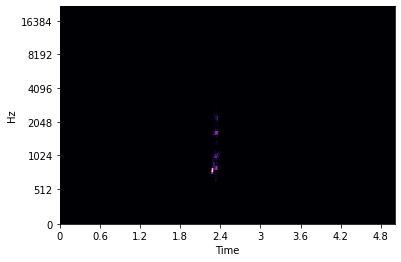

In [20]:
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')

На изображении не так много информации. 

Можно это улучшить! Если конвертировать спектрограмму в логарифмическую шкалу, то структуры звука станут лучше, поскольку шкала будет представлять более широкий диапазон значений. В обработке аудиоданных этот метод достаточно распространён, и у **LibROSA** есть для этого специальный код:

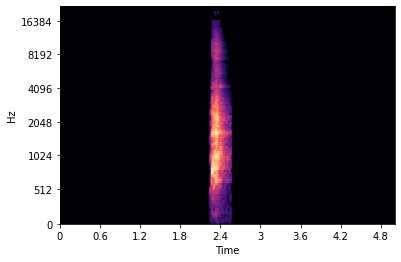

In [21]:
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')

Теперь у нас есть логарифмическая мел-спектрограмма! Если вы вызовете `log_spectrogram.shape`, то увидите, что это 2D-тензор, что логично, так как мы построили график изображений с помощью тензора.

In [22]:
log_spectrogram.shape

(128, 431)

Мы могли бы создать новую архитектуру нейронной сети и передать в неё новые данные, но у меня в рукаве припасен дьявольский трюк. Буквально только **что мы сгенерировали изображения данных спектрограммы. Почему бы не поработать с ними?**

**Поначалу такое решение может показаться глупым; в конце концов, у нас есть основные данные спектрограммы, которые точнее, чем представление изображения** (если мы видим, что значение точки данных соответствует 58, а не 60, то для нас это значит больше, чем другой оттенок, например фиолетовый). И если бы мы начинали с нуля, так бы оно и было. Но! У нас уже есть обученные сети, такие как **ResNet** и **Inception**, которые, как мы знаем, прекрасно распознают структуру и другие части изображений. Мы можем создавать представления изображений нашего аудио и использовать предварительно обученную сеть, чтобы значительно улучшить точность при небольшом обучении, используя сверхмощный перенос обучения ещё раз. Для нашего набора данных это может быть подходящим решением, так как у нас не так много примеров для обучения сети (всего 2000!).

**Этот приём можно использовать во многих разнородных наборах данных. Если вы найдёте способ, как можно недорого преобразовать данные в представление изображения, стоит им воспользоваться и применить сеть ResNet, чтобы оценить, на что способен перенос обучения, и иметь представление о том, с чем придётся столкнуться, если вы решите воспользоваться другим подходом.** Теперь давайте создадим новый набор данных, который будет генерировать эти изображения по запросу.

##Новый набор данных
Отбросьте исходный класс набора данных **ESC50** и создайте новый **ESC50Spectrogram**. Несмотря на то что это отделит некоторую часть кода от старого класса, в этой версии методом `__get_item__` можно получить гораздо больше. Мы генерируем спектрограмму с помощью **LibROSA**, а затем делаем некоторые манипуляции с `matplotlib`, чтобы получить данные в массив **NumPy**. Мы применяем массив к нашему конвейеру преобразования (который просто использует `ToTensor`) и возвращаем его и маркировку элемента. Вот код, который мы можем для этого использовать (но, не будем использовать):

In [ ]:
'''
class ESC50Spectrogram(Dataset):
def __init__(self,path):
    files = Path(path).glob('*.wav')
    self.items = [(f,int(f.name.split("-")[-1].replace(".wav","")))
                 for f in files]
    self.length = len(self.items)
    self.transforms = torchvision.transforms.Compose(
                 [torchvision.transforms.ToTensor()])
def __getitem__(self, index):
    filename, label = self.items[index]
    audio_tensor, sample_rate = librosa.load(filename, sr=None)
    spectrogram = librosa.feature.melspectrogram(audio_tensor, sr=sample_rate)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(log_spectrogram, sr=sample_rate,
                             x_axis='time', y_axis='mel')
    plt.gcf().canvas.draw()
    audio_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    audio_data = audio_data.reshape(fig.canvas.get_width_height()
                             [::-1] + (3,))
    return (self.transforms(audio_data), label)
def __len__(self):
    return self.length
'''

Мы не станем тратить слишком много времени на эту версию набора данных, потому что в ней есть большой недостаток, который я продемонстрирую с помощью метода `Python process_time()`:

In [ ]:
'''
oldESC50 = ESC50("ESC-50/train/")
start_time = time.process_time()
oldESC50.__getitem__(33)
end_time = time.process_time()
old_time = end_time - start_time
newESC50 = ESC50Spectrogram("ESC-50/train/")
start_time = time.process_time()
newESC50.__getitem__(33)
end_time = time.process_time()
new_time = end_time - start_time
old_time = 0.004786839000075815
new_time = 0.39544327499993415
'''

**Новый набор данных почти в сто раз медленнее**, чем исходный, который только что вернул необработанный звук! Обучение становится невероятно медленным и может даже свести на нет любые преимущества переноса обучения.

Мы можем использовать несколько способов, которые решают большинство наших проблем. Первый подход заключается в добавлении кэша для хранения сгенерированной спектрограммы в памяти, поэтому нам не нужно восстанавливать её каждый раз, когда мы вызываем метод `__getitem__`. С пакетом **Python functools** это легко:

In [ ]:
'''
import functools
class ESC50Spectrogram(Dataset):
 # skipping init code
    @functools.lru_cache(maxsize=<size of dataset>)
    def __getitem__(self, index):
'''

При условии, что оперативной памяти достаточно для хранения всего содержимого набора данных, этого может быть вполне достаточно. 

Мы настроили давно не используемый кэш (**LRU**), который будет сохранять содержимое в памяти как можно дольше, причем при загрузке памяти индексы, к которым давно не обращались, будут извлекаться из кэша в первую очередь. 

**Однако если у вас недостаточно памяти для хранения, на каждой итерации пакета вы столкнетесь с медленной работой, так как удаленные спектрограммы придется восстанавливать.** Я предпочитаю *предварительно вычислить* все возможные графики, а затем создать новый пользовательский класс набора данных, который загружает эти изображения с диска. (Вы также можете добавить аннотацию кэша LRU для дальнейшего ускорения.)

Для *предварительного вычисления* не нужно делать ничего сверхъестественного, это просто метод, который сохраняет графики в том же каталоге, через который они проходят (см. код в следующей ячейке).

Этот метод проще, чем наш предыдущий набор данных, потому что мы можем использовать метод `savefig` от **matplotlib** для сохранения графика непосредственно на диск, вместо того чтобы возиться с **NumPy**. Мы также предоставляем дополнительный входной параметр, ``dpi``, который позволяет нам контролировать качество сгенерированных выходных данных. Запустите его на всех путях обучения, тестирования и валидации, которые мы уже настроили (скорее всего, потребуется **несколько часов**, чтобы пройти через все изображения).



---



In [24]:
# Директория сохранения изображений спектрограмм 
# path2audio = "/content/ESC-50-master/audio/"
path2audio = "/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/"


PATH_ESC50_TRAIN = (path2audio + "train/")
PATH_ESC50_VALID = (path2audio + "valid/")


print("Директории хранения набора данных и сохранения их мел-спектрограмм:")
print(path2audio)
print(PATH_ESC50_TRAIN)
print(PATH_ESC50_VALID)

Директории для сохранения набора данных:
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/valid/


Далее используются модули `Path` (из `pathlib`) и `glob`.
Документация модуля `Path` по [ссылке](https://docs.python.org/3/library/pathlib.html). Документация модуля `glob` по [ссылке](https://docs.python.org/3/library/glob.html?highlight=glob#module-glob).
Примеры испоьзования модулей см. ниже.

In [43]:
# примеры использования модулей pathlib и glob

fls = glob.glob(path2audio+'train/*', recursive=True)
print("Файлы в директории ..train:")
print(fls)

# модуль glob возвращает список файлов с именами, заданными шаблоном
fls = glob.glob(path2audio+ '**/*', recursive=True)
print("Файлы в директории и поддиректориях:")
print(fls)


ph = Path(path2audio+"train/")
print("Путь:")
print(ph)

# СОвместрое использование Path и glob генерит список файлов
# https://docs.python.org/3/library/pathlib.html#concrete-paths
# например, для комады сортировать" задаёт список файлов, который нужно отсортировать
print("Генератор списка файлов:")
print(Path.glob(ph,'*.wav'))
flist = sorted(Path.glob(ph,'*.wav'))
print("...и список файлов, с именем по шаблону, в указанной директории:")
print(flist)


Файлы в директории ..train:
['/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-100032-A-0.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-100038-A-14.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-100210-A-36.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-100210-B-36.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-101296-A-19.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-101296-B-19.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-101336-A-30.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-101404-A-34.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-103298-A-9.wav', '/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio

In [44]:
def precompute_spectrograms(path, dpi=50):
    files = Path(path).glob('*.wav')  
    for filename in files:
        print(filename)
        audio_tensor, sr = librosa.load(filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(audio_tensor, sr=sr)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel') 
        plt.gcf().savefig("{}{}_{}.png".format(filename.parent,dpi,filename.name), dpi=dpi)
        # в предыдущей строке задан шаблон имени файла изображения - "{}{}_{}.png"
        # filename.parent - имя директории, где хранится файл filename (директории с идексом =0, parent[0])
        # dpi - разрешение изображения
        # filename.name - имя файла filename

In [ ]:
precompute_spectrograms(PATH_ESC50_TRAIN)
precompute_spectrograms(PATH_ESC50_VALID)

/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-100032-A-0.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-100038-A-14.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-100210-A-36.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-100210-B-36.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-101296-A-19.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-101296-B-19.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-101336-A-30.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-101404-A-34.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-103298-A-9.wav
/gdrive/MyDrive/Colab_Notebooks/audio_classification/ESC-50-master/audio/train/1-103995-A-30.wav
/gdrive/MyDrive/Colab_Notebooks/

Все, что сейчас нужно, — это новый набор данных, который читает эти изображения. Мы не можем использовать стандартный `ImageDataLoader`, о котором шла речь в главах 2–4, поскольку схема имени файла PNG не соответствует используемой им структуре каталогов. Но независимо от этого, мы можем просто открыть изображение с помощью **Python Imaging Library**:

In [ ]:
# ВАРИАНТ КОДА ИЗ РЕПОЗИТОРИЯ АВТОРА КНИГИ. С ним появляется ошибка в след. модуле !
class PrecomputedESC50(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        # files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))       # версия из репозитория. Код в следующей ячейке ругается на name
        files = Path(path).glob('{}{}*.wav.png'.format(path, dpi))              # моя версия
        # files = Path(path).glob('{}*.wav.png'.format(dpi))                    # версия из книги
        self.items = [(f,int(f.name.split("-")[-1].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])   # в варианте кода из книги применено torchvision.transforms.Compose
        else:
            self.img_transforms = img_transforms  # если задан img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB') # в варианте кода из книги картинка не конвертируется в RGB
        print(filename)
        return (self.img_transforms(img), label)


    def __len__(self):
        return self.length

В варианте кода из репозитория картинки конвертируются в формат RGB. Видимо из-за этого не работает последующая ячека с кодом (после кода с вариантом из книги). Описание конвертирования изображений библиотекой PIL описано по [ссылке](https://pillow.readthedocs.io/en/stable/handbook/tutorial.html#converting-between-modes)

In [ ]:
'''
# ВАРИАНТ КОДА ИЗ КНИГИ
class PrecomputedESC50(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}*.wav.png'.format(dpi))

        self.items = [(f,int(f.name.split("-")[-1].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename)              # в варианте кода из репозитория картинка конвертируется в RGB
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length
'''

## Pretrained ResNet50

In [ ]:
spec_resnet = models.resnet50(pretrained=True)

for param in spec_resnet.parameters():
    param.requires_grad = False

spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features,500),
                               nn.ReLU(),
                               nn.Dropout(), 
                               nn.Linear(500,50))

In [ ]:
esc50pre_train = PrecomputedESC50(PATH_ESC50_TRAIN,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                           std=[0.229, 0.224, 0.225])]))

esc50pre_valid = PrecomputedESC50(PATH_ESC50_VALID,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50_train_loader = torch.utils.data.DataLoader(esc50pre_train, bs, shuffle=True)
esc50_val_loader = torch.utils.data.DataLoader(esc50pre_valid, bs, shuffle=True)

In [ ]:
esc50pre_train = PrecomputedESC50(PATH_ESC50_TRAIN, transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                                                 std=[0.229, 0.224, 0.225])]))

esc50pre_valid = PrecomputedESC50(PATH_ESC50_VALID, transforms=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                                                 std=[0.229, 0.224, 0.225])]))                                                                                                                  
esc50_train_loader = torch.utils.data.DataLoader(esc50pre_train, bs, shuffle=True)
esc50_val_loader = torch.utils.data.DataLoader(esc50pre_valid, bs, shuffle=True)

In [ ]:
spec_resnet.to(device) 
torch.save(spec_resnet.state_dict(), "spec_resnet.pth")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(spec_resnet.parameters(), lr=lr)
logs,losses = find_lr(spec_resnet, loss_fn, optimizer, esc50_train_loader, device=device)
plt.plot(logs, losses)

In [ ]:
spec_resnet.load_state_dict(torch.load("spec_resnet.pth"))
optimizer = optim.Adam([
                        {'params': spec_resnet.conv1.parameters()},
                        {'params': spec_resnet.bn1.parameters()},
                        {'params': spec_resnet.relu.parameters()},
                        {'params': spec_resnet.maxpool.parameters()},
                        {'params': spec_resnet.layer1.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer2.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer3.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer4.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.avgpool.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.fc.parameters(), 'lr': 1e-8}
                        ], lr=1e-2)

train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=5, device=device)

for param in spec_resnet.parameters():
    param.requires_grad = True

train(spec_resnet, optimizer, nn.CrossEntropyLoss(), esc50_train_loader, esc50_val_loader, epochs=5, device=device)

## Data Augmentation

In [ ]:
class ESC50WithPitchChange(Dataset):

    def __init__(self,path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(f,f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
        self.E = torchaudio.sox_effects.SoxEffectsChain()
        self.E.append_effect_to_chain("pitch", [0.5])
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        self.E.set_input_file(filename)
        audio_tensor, sample_rate = self.E.sox_build_flow_effects()
        return audio_tensor, label
        
    def __len__(self):
        return self.length

In [ ]:
class FrequencyMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     FrequencyMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the frequency 
            mask is to be applied.

        Returns:
            Tensor: Transformed image with Frequency Mask.
        """
        start = random.randrange(0, tensor.shape[2])
        end = start + random.randrange(1, self.max_width)
        if self.use_mean:
            tensor[:, start:end, :] = tensor.mean()
        else:
            tensor[:, start:end, :] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')

        return format_string

In [ ]:
transforms.Compose([FrequencyMask(max_width=10, use_mean=False),
transforms.ToPILImage()])(torch.rand(3,250,200))

In [ ]:
class TimeMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     TimeMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the time mask 
            is to be applied.

        Returns:
            Tensor: Transformed image with Time Mask.
        """
        start = random.randrange(0, tensor.shape[1])
        end = start + random.randrange(0, self.max_width)
        if self.use_mean:
            tensor[:, :, start:end] = tensor.mean()
        else:
            tensor[:, :, start:end] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')
        return format_string

In [ ]:
transforms.Compose([TimeMask(max_width=10, use_mean=False),
transforms.ToPILImage()])(torch.rand(3,250,200))

In [ ]:
class PrecomputedTransformESC50(Dataset):
    def __init__(self, path, max_freqmask_width, max_timemask_width, use_mean=True, dpi=50):
        files = Path(path).glob('{}*.wav.png'.format(dpi))
        self.items = [(f,f.name.split("-")[-1].replace(".wav.png","")) for f in files]
        self.length = len(self.items)
        self.max_freqmask_width = max_freqmask_width
        self.max_timemask_width = max_timemask_width
        self.use_mean = use_mean
        self.img_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomApply([FrequencyMask(self.max_freqmask_width, self.use_mean)], p=0.5),
            transforms.RandomApply([TimeMask(self.max_timemask_width, self.use_mean)], p=0.5)
])
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename)
        return (self.img_transforms(img), label)
        
    def __len__(self):
        return self.length